In [21]:
import os

img_dir = "./testure test images/"

test_images = [
    os.path.join(img_dir, 'image1.png'),
    os.path.join(img_dir, 'image2.png'),
]

ground_truths = [
    os.path.join(img_dir, 'image1_groundtruth.png'),
    os.path.join(img_dir, 'image2_groundtruth.png'),
]

Using image folder: ./texture test images
Could not import detect1 (fallback to local helpers): No module named 'detect1'
Found images: ['./texture test images\\image1.png', './texture test images\\image2.png']
Found ground-truths: ['./texture test images\\image1_groundtruth.png', './texture test images\\image2_groundtruth.png']
No saved prediction for image1 - running detector
No saved prediction for image2 - running detector


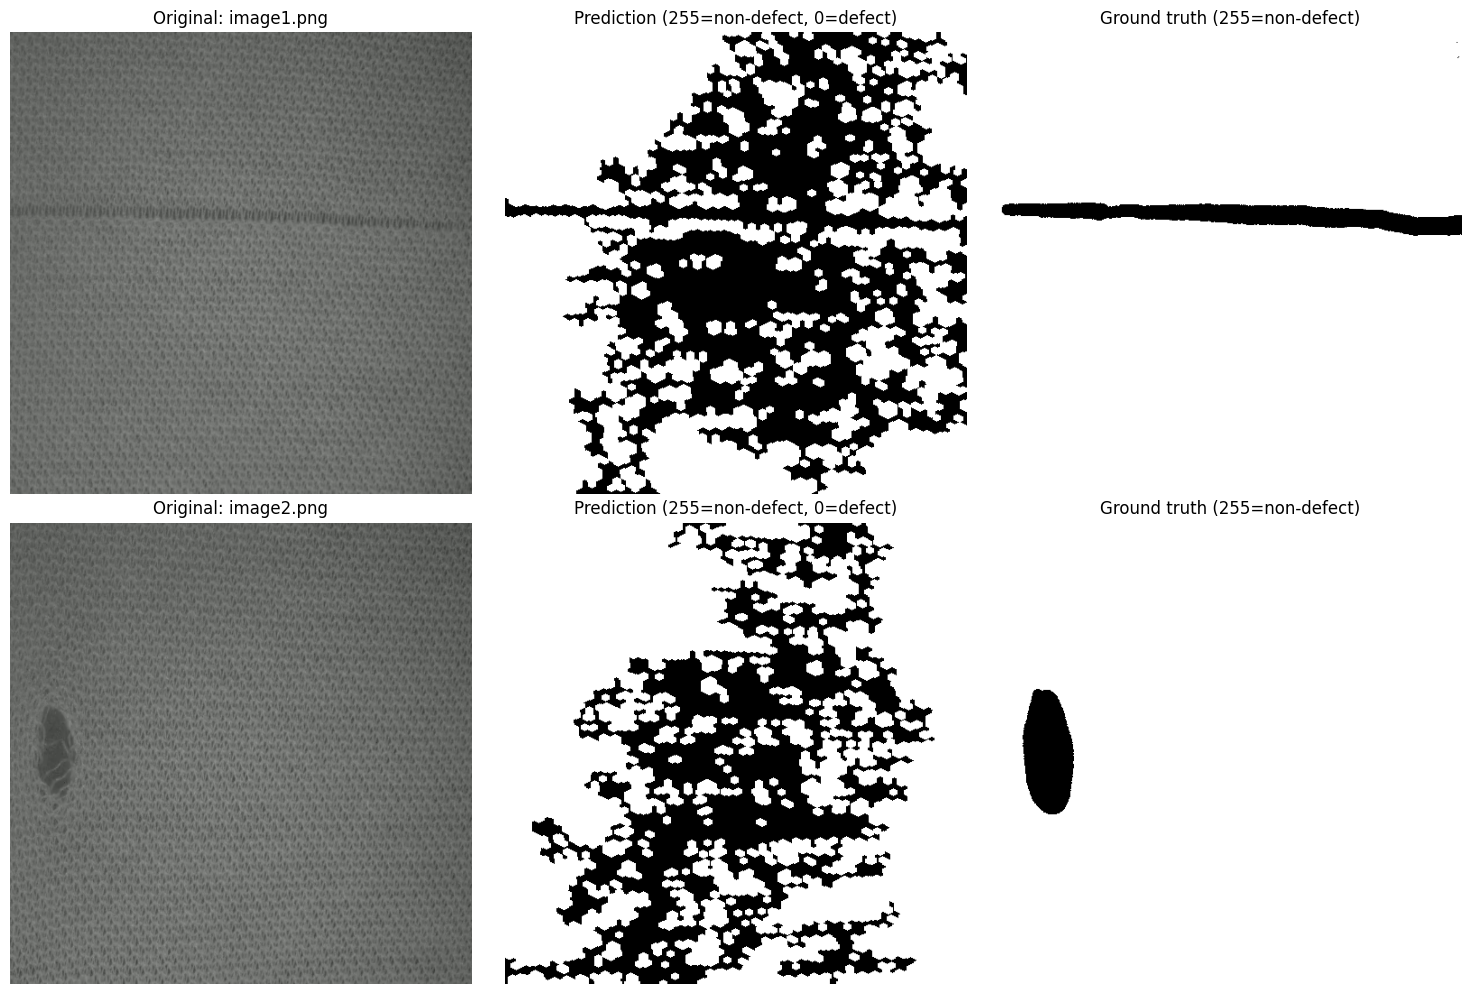

In [22]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

# locate image folder robustly
candidates = ['./texture test images', './texture test images/', './testure test images', './testure test images/']
img_folder = None
for c in candidates:
    if os.path.isdir(c):
        img_folder = c
        break
if img_folder is None:
    raise FileNotFoundError('Could not find image folder. Expected one of: ' + ', '.join(candidates))
print('Using image folder:', img_folder)

# try to reuse detect1 from tests if available
repo_root = os.path.abspath('.')
tests_dir = os.path.join(repo_root, 'tests')
if tests_dir not in sys.path:
    sys.path.insert(0, tests_dir)

try:
    import detect1
    from detect1 import read_image, ensure_mask, find_image_and_gt_pairs, detect_defect_texture
    print('Imported detect1 functions')
except Exception as e:
    print('Could not import detect1 (fallback to local helpers):', e)
    def read_image(p):
        im = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if im is None:
            raise FileNotFoundError(p)
        if im.ndim == 3 and im.shape[2] == 4:
            im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGB)
        elif im.ndim == 3 and im.shape[2] == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im
    def ensure_mask(m):
        if m.ndim == 3:
            m = cv2.cvtColor(m, cv2.COLOR_RGB2GRAY)
        return (m > 0).astype(np.uint8)
    def find_image_and_gt_pairs(folder):
        exts = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
        files = [f for f in os.listdir(folder) if f.lower().endswith(exts)]
        files.sort()
        imgs = [os.path.join(folder, 'image1.png'), os.path.join(folder, 'image2.png')]
        gts = [os.path.join(folder, 'image1_groundtruth.png'), os.path.join(folder, 'image2_groundtruth.png')]
        imgs = [p for p in imgs if os.path.isfile(p)]
        gts = [p for p in gts if os.path.isfile(p)]
        if len(imgs) == 0:
            raise FileNotFoundError('No standard images found in ' + folder)
        return imgs, gts
    def detect_defect_texture(im, blackhat_kernel=31, small_morph=5):
        if im.ndim == 3:
            gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        else:
            gray = im.copy()
        gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
        k = max(3, blackhat_kernel | 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
        blackhat = cv2.morphologyEx(gray_blur, cv2.MORPH_BLACKHAT, kernel)
        bh = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, bw = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        sk = max(3, small_morph | 1)
        small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sk, sk))
        bw_open = cv2.morphologyEx(bw, cv2.MORPH_OPEN, small_kernel, iterations=1)
        bw_clean = cv2.morphologyEx(bw_open, cv2.MORPH_CLOSE, small_kernel, iterations=2)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bw_clean, connectivity=8)
        if num_labels <= 1:
            return np.ones_like(bw_clean, dtype=np.uint8) * 255
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_idx = 1 + int(np.argmax(areas))
        defect_foreground = (labels == largest_idx).astype(np.uint8) * 255
        final_mask = 255 - defect_foreground
        return final_mask

# Find images and ground-truths
img_paths, gt_paths = find_image_and_gt_pairs(img_folder)
print('Found images:', img_paths)
print('Found ground-truths:', gt_paths)

# For each image: load original, predicted (if saved), and ground-truth, then plot
pred_dirs = ['./results_best', './results']
rows = len(img_paths)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, 3)

for i, (img_p, gt_p) in enumerate(zip(img_paths, gt_paths)):
    orig = read_image(img_p)
    base = os.path.splitext(os.path.basename(img_p))[0]
    pred_img = None
    for d in pred_dirs:
        cand = os.path.join(d, base + '_pred.png')
        if os.path.isfile(cand):
            pm = cv2.imread(cand, cv2.IMREAD_UNCHANGED)
            if pm is not None and pm.ndim == 3:
                ch = pm.shape[2] if pm.ndim == 3 else 1
                if ch >= 3:
                    pm = cv2.cvtColor(pm, cv2.COLOR_BGR2GRAY)
                elif ch == 1:
                    pm = pm[:, :, 0]
            pred_img = pm
            print('Loaded prediction from', cand)
            break
    if pred_img is None:
        print('No saved prediction for', base, '- running detector')
code
python
# Master evaluator: grid-search parameters across detectors, pick best vs ground truth
# Saves per-method best masks to ./results_maximize/<method>_best and plots comparisons.
import os, sys, cv2, numpy as np, matplotlib.pyplot as plt
from itertools import product

out_max = './results_maximize'
os.makedirs(out_max, exist_ok=True)

# helpers: metrics and safe GT load
try:
    compute_metrics  # from earlier cell
except NameError:
    def compute_metrics(pred_mask: np.ndarray, gt_mask: np.ndarray):
        pred_bin = (pred_mask == 0).astype(np.uint8)
        gt_bin = (gt_mask == 0).astype(np.uint8)
        tp = int(np.logical_and(pred_bin==1, gt_bin==1).sum())
        tn = int(np.logical_and(pred_bin==0, gt_bin==0).sum())
        fp = int(np.logical_and(pred_bin==1, gt_bin==0).sum())
        fn = int(np.logical_and(pred_bin==0, gt_bin==1).sum())
        total = tp+tn+fp+fn
        acc = (tp+tn)/total if total>0 else 0.0
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1 = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
        return tp,tn,fp,fn,acc,prec,rec,f1

def load_gt_safe(path, shape):
    if path is not None and os.path.isfile(path):
        gt_raw = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if gt_raw is not None:
            if gt_raw.ndim == 3:
                ch = gt_raw.shape[2]
                if ch >= 3:
                    gt = cv2.cvtColor(gt_raw, cv2.COLOR_BGR2GRAY)
                else:
                    gt = gt_raw[:, :, 0]
            else:
                gt = gt_raw
            # resize if mismatched (shouldn't happen in this dataset)
            if gt.shape[:2] != shape[:2]:
                gt = cv2.resize(gt, (shape[1], shape[0]), interpolation=cv2.INTER_NEAREST)
            return gt
    return np.ones(shape[:2], dtype=np.uint8)*255

# patch cropping for fast search (optional)
def center_patch(img, gt, ratio=0.6):
    h,w = img.shape[:2]
    ph, pw = max(32, int(h*ratio)), max(32, int(w*ratio))
    y0 = (h - ph)//2; x0 = (w - pw)//2
    img_p = img[y0:y0+ph, x0:x0+pw].copy()
    gt_p = gt[y0:y0+ph, x0:x0+pw].copy()
    return img_p, gt_p

# Ensure required functions exist (defined earlier in notebook).
# If not, raise clear errors to nudge running previous cells.
required_funcs = ['detect_skimage_fusion','gabor_texture_map','simple_refine','edge_proposal','multi_scale_blackhat']
for fn in required_funcs:
    if fn not in globals():
        raise RuntimeError(f'Required function {fn} not found. Please run previous cells first.')

# Optional advanced functions
has_adv = ('texture_normalize' in globals()) and ('frangi_detector' in globals()) and ('hough_line_detector' in globals())
# Optional YOLO
has_yolo = False
try:
    from ultralytics import YOLO
    has_yolo = True
except Exception:
    has_yolo = False

# Wrap detectors into callables with params
def run_fusion(im, params):
    mask, _ = detect_skimage_fusion(im, bh_kernel=params.get('bh_kernel',31), lbp_P=8, lbp_R=1, entropy_disk=params.get('entropy_disk',7), weights=params.get('weights',(0.5,0.25,0.25)), min_area=params.get('min_area',30))
    return mask

def run_proposal_simple(im, params):
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) if im.ndim==3 else im
    _, fused_u8 = detect_skimage_fusion(im)
    texture = gabor_texture_map(gray)
    mask, _ = simple_refine(im, fused_u8, texture,
                             fused_percentile=params.get('fused_percentile',99.5),
                             seed_percentile=99.9,
                             mean_accept=params.get('mean_accept',0.5),
                             min_area=params.get('min_area',80),
                             close_kernel=params.get('close_kernel',(25,3)))
    return mask

def run_edge_aug(im, params):
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) if im.ndim==3 else im
    _, fused_u8 = detect_skimage_fusion(im)
    # adjust fused gating percentile inside wrapper
    gate = params.get('fused_gate_percentile',95)
    # temporary mask by overriding gating via pre-thresholding
    fuse_mask = fused_u8 >= np.percentile(fused_u8, gate)
    edge_mask = edge_proposal(im, fused_u8=fused_u8)
    bhm = multi_scale_blackhat(gray)
    mask_bh = np.ones_like(gray, dtype=np.uint8)*255; mask_bh[bhm>0] = 0
    try:
        hm = hole_detector(gray)
    except Exception:
        hm = mask_bh
    combined = np.logical_or.reduce([(edge_mask==0), (mask_bh==0), (hm==0), fuse_mask])
    res = np.ones_like(gray, dtype=np.uint8)*255; res[combined]=0
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (params.get('close_k',7), params.get('close_k2',7)))
    fm = cv2.morphologyEx((res==0).astype(np.uint8)*255, cv2.MORPH_CLOSE, k, iterations=1)
    from skimage.morphology import remove_small_objects
    fm_bool = remove_small_objects(fm.astype(bool), min_size=params.get('min_size',40))
    out = np.ones_like(res); out[fm_bool]=0
    return out

def run_advanced(im, params):
    if not has_adv:
        raise RuntimeError('Advanced functions not available')
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) if im.ndim==3 else im
    norm = texture_normalize(gray, open_size=params.get('open_size',61))
    fr_mask, _ = frangi_detector(norm, scale_range=(1,6), scale_step=1, thresh_percentile=params.get('frangi_thr',98.0))
    hough_mask = hough_line_detector(norm, canny_low=30, canny_high=120, min_len_ratio=params.get('min_len_ratio',0.3), thickness=params.get('thickness',9))
    try:
        hole_mask = hole_detector(gray)
    except Exception:
        hole_mask = fr_mask
    try:
        simple_mask, _ = simple_refine(im, detect_skimage_fusion(im)[1], gabor_texture_map(gray), fused_percentile=99.0, seed_percentile=99.9, mean_accept=0.45, min_area=40, close_kernel=(15,3))
    except Exception:
        simple_mask = fr_mask
    combined = np.logical_or.reduce([(fr_mask==0), (hough_mask==0), (hole_mask==0), (simple_mask==0)])
    res = np.ones_like(gray, dtype=np.uint8)*255; res[combined]=0
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,3))
    fm = cv2.morphologyEx((res==0).astype(np.uint8)*255, cv2.MORPH_CLOSE, k, iterations=1)
    from skimage.morphology import remove_small_objects
    fm_bool = remove_small_objects(fm.astype(bool), min_size=50)
    out = np.ones_like(res); out[fm_bool]=0
    return out

def run_hybrid_yolo(im, params):
    if not has_yolo:
        raise RuntimeError('YOLO not available')
    model = YOLO('yolov8n.pt')
    h,w = im.shape[:2]
    full_mask = np.ones((h,w), dtype=np.uint8)*255
    res = model(im, imgsz=640, conf=params.get('conf',0.25))
    boxes = []
    try:
        for box in res[0].boxes.xyxy.cpu().numpy(): boxes.append(box)
    except Exception:
        if hasattr(res[0],'boxes'):
            for b in res[0].boxes: boxes.append(b.xyxy.tolist()[0])
    if len(boxes)==0:
        return run_fusion(im, {'bh_kernel':31,'entropy_disk':7,'min_area':30})
    for b in boxes:
        x1,y1,x2,y2 = map(int, b[:4])
        x1=max(0,x1); y1=max(0,y1); x2=min(w,x2); y2=min(h,y2)
        if x2>x1 and y2>y1:
            full_mask[y1:y2, x1:x2] = 0
    return full_mask

# Parameter grids (kept small to be practical)
fusion_grid = [{ 'bh_kernel':k, 'entropy_disk':ed, 'weights':wt, 'min_area':ma }
               for k in [21,31,41]
               for ed in [5,7]
               for wt in [(0.6,0.25,0.15),(0.5,0.25,0.25),(0.4,0.35,0.25)]
               for ma in [20,50]]
simple_grid = [{ 'fused_percentile':fp, 'mean_accept':ma, 'min_area':mn }
               for fp in [97,99]
               for ma in [0.45,0.55]
               for mn in [50,100]]
edgeaug_grid = [{ 'fused_gate_percentile':pg, 'min_size':ms }
               for pg in [90,95,97]
               for ms in [40,80]]
adv_grid = [{ 'frangi_thr':ft, 'min_len_ratio':ml, 'thickness':th }
            for ft in [97.0,98.0,99.0]
            for ml in [0.25,0.35]
            for th in [7,11]] if has_adv else []
yolo_grid = [{ 'conf':c } for c in [0.25,0.35]] if has_yolo else []

# Images and GTs
img_list, gt_list = find_image_and_gt_pairs(img_folder)

# Evaluate function
def eval_method(name, runner, grid, use_patches=False, patch_ratio=0.6):
    best = {'params': None, 'mean_f1': -1.0, 'per_image': None}
    for params in grid if grid else [{}]:
        f1s = []; per_img = []
        for i, p in enumerate(img_list):
            im = read_image(p)
            gt = load_gt_safe(gt_list[i] if i < len(gt_list) else None, im)
            im_e, gt_e = (center_patch(im, gt, ratio=patch_ratio) if use_patches else (im, gt))
            try:
                pred = runner(im_e, params)
            except Exception as e:
                print(f'[WARN] {name} failed on {os.path.basename(p)} with params {params}:', e)
                pred = np.ones(gt_e.shape, dtype=np.uint8)*255
            _,_,_,_,_,_,_,f1 = compute_metrics(pred, gt_e)
            f1s.append(f1); per_img.append((p, f1, pred))
        m = float(np.mean(f1s)) if f1s else -1.0
        if m > best['mean_f1']:
            best = {'params': params, 'mean_f1': m, 'per_image': per_img}
    # save masks for best params (full images)
    out_dir = os.path.join(out_max, f'{name}_best')
    os.makedirs(out_dir, exist_ok=True)
    saved = []
    for i, p in enumerate(img_list):
        im = read_image(p); gt = load_gt_safe(gt_list[i] if i < len(gt_list) else None, im)
        pred = runner(im, best['params'] or {})
        outp = os.path.join(out_dir, os.path.splitext(os.path.basename(p))[0] + '_pred.png')
        cv2.imwrite(outp, pred)
        _,_,_,_,acc,prec,rec,f1 = compute_metrics(pred, gt)
        saved.append((p, outp, acc, prec, rec, f1))
    return best, saved

results_summary = {}
# Run evaluations (enable patch mode for speed on large sets)
best_fusion, saved_fusion = eval_method('fusion', run_fusion, fusion_grid, use_patches=True)
print('Fusion best:', best_fusion['mean_f1'], best_fusion['params'])
best_simple, saved_simple = eval_method('proposal_simple', run_proposal_simple, simple_grid, use_patches=True)
print('Proposal-simple best:', best_simple['mean_f1'], best_simple['params'])
best_edge, saved_edge = eval_method('edge_aug', run_edge_aug, edgeaug_grid, use_patches=True)
print('Edge-aug best:', best_edge['mean_f1'], best_edge['params'])
if has_adv:
    best_adv, saved_adv = eval_method('advanced', run_advanced, adv_grid, use_patches=True)
    print('Advanced best:', best_adv['mean_f1'], best_adv['params'])
else:
    best_adv, saved_adv = ({'mean_f1':-1.0,'params':None}, [])
if has_yolo:
    best_yolo, saved_yolo = eval_method('hybrid_yolo', run_hybrid_yolo, yolo_grid, use_patches=False)
    print('YOLO best:', best_yolo['mean_f1'], best_yolo['params'])
else:
    best_yolo, saved_yolo = ({'mean_f1':-1.0,'params':None}, [])

# Aggregate mean F1 by method
method_scores = {
    'fusion': best_fusion['mean_f1'],
    'proposal_simple': best_simple['mean_f1'],
    'edge_aug': best_edge['mean_f1'],
}
if has_adv: method_scores['advanced'] = best_adv['mean_f1']
if has_yolo: method_scores['hybrid_yolo'] = best_yolo['mean_f1']
best_method = max(method_scores.items(), key=lambda x: x[1])[0]
print('Overall best method:', best_method, 'mean F1=', method_scores[best_method])

# Per-image: pick best among saved predictions
per_image_best = []
saved_by_method = {
    'fusion': saved_fusion,
    'proposal_simple': saved_simple,
    'edge_aug': saved_edge
}
if has_adv: saved_by_method['advanced'] = saved_adv
if has_yolo: saved_by_method['hybrid_yolo'] = saved_yolo

out_bestpi = os.path.join(out_max, 'best_per_image')
os.makedirs(out_bestpi, exist_ok=True)
for i, p in enumerate(img_list):
    im = read_image(p); gt = load_gt_safe(gt_list[i] if i < len(gt_list) else None, im)
    best_f1 = -1.0; best_mask = None; best_name = None
    for mname, saved in saved_by_method.items():
        # find this image in saved list
        for (pp, outp, acc, prec, rec, f1) in saved:
            if os.path.basename(pp) == os.path.basename(p):
                if f1 > best_f1:
                    best_f1 = f1; best_name = mname; best_mask = cv2.imread(outp, cv2.IMREAD_UNCHANGED)
                break
    if best_mask is None:
        best_mask = np.ones((im.shape[0], im.shape[1]), dtype=np.uint8)*255; best_name = 'none'
    outp = os.path.join(out_bestpi, os.path.splitext(os.path.basename(p))[0] + '_pred.png')
    cv2.imwrite(outp, best_mask)
    per_image_best.append((p, outp, best_name, best_f1))
    print('Best for', os.path.basename(p), '->', best_name, 'F1=', f1)

# Plot comparisons: Original | GT | Best Mask | Overlay diff
n = len(img_list)
fig, axs = plt.subplots(n, 4, figsize=(20, 5*n))
if n==1: axs = axs.reshape(1,4)
for i, (p, outp, best_name, best_f1) in enumerate(per_image_best):
    im = read_image(p)
    gt = load_gt_safe(gt_list[i] if i < len(gt_list) else None, im)
    pred = cv2.imread(outp, cv2.IMREAD_UNCHANGED)
    axs[i,0].imshow(im); axs[i,0].axis('off'); axs[i,0].set_title(f'Original: {os.path.basename(p)}')
    axs[i,1].imshow(gt, cmap='gray', vmin=0, vmax=255); axs[i,1].axis('off'); axs[i,1].set_title('GT')
    axs[i,2].imshow(pred, cmap='gray', vmin=0, vmax=255); axs[i,2].axis('off'); axs[i,2].set_title(f'Best Mask ({best_name})')
    # overlay: red = pred defect, green = GT defect
    h,w = gt.shape[:2]
    overlay = np.zeros((h,w,3), dtype=np.uint8)
    pred_def = (pred==0); gt_def = (gt==0)
    overlay[gt_def] = (0,255,0)
    overlay[pred_def] = (255,0,0)
    axs[i,3].imshow(cv2.addWeighted(im if im.ndim==3 else cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), 0.6, overlay, 0.4, 0))
    axs[i,3].axis('off'); axs[i,3].set_title('Overlay (red=pred, green=GT)')
plt.tight_layout(); plt.show()

# Plot method mean F1 bar chart
labels = list(method_scores.keys()); scores = [method_scores[k] for k in labels]
plt.figure(figsize=(8,4)); plt.bar(labels, scores, color='skyblue');
for i,s in enumerate(scores): plt.text(i, s+1e-3, f'{s:.3f}', ha='center')
plt.ylabel('Mean F1'); plt.title('Detector mean F1 (higher is better)'); plt.ylim(0,1.0); plt.show()

print('Evaluation complete. Results saved under', out_max)
        pred_img = detect_defect_texture(orig)
    # load ground-truth
    if os.path.isfile(gt_p):
        gt_raw = cv2.imread(gt_p, cv2.IMREAD_UNCHANGED)
        if gt_raw is None:
            raise FileNotFoundError('Could not read GT: '+gt_p)
        if gt_raw.ndim == 3:
            ch = gt_raw.shape[2]
            if ch >= 3:
                gt_gray = cv2.cvtColor(gt_raw, cv2.COLOR_BGR2GRAY)
            elif ch == 1:
                gt_gray = gt_raw[:, :, 0]
            else:
                gt_gray = gt_raw[:, :, 0]
        else:
            gt_gray = gt_raw
    else:
        gt_gray = np.ones((orig.shape[0], orig.shape[1]), dtype=np.uint8) * 255

    # Plot original
    ax0 = axes[i, 0]
    ax0.imshow(orig)
    ax0.set_title(f'Original: {os.path.basename(img_p)}')
    ax0.axis('off')
    # Plot prediction
    ax1 = axes[i, 1]
    ax1.imshow(pred_img, cmap='gray', vmin=0, vmax=255)
    ax1.set_title('Prediction (255=non-defect, 0=defect)')
    ax1.axis('off')
    # Plot GT
    ax2 = axes[i, 2]
    ax2.imshow(gt_gray, cmap='gray', vmin=0, vmax=255)
    ax2.set_title('Ground truth (255=non-defect)')
    ax2.axis('off')

plt.tight_layout()
plt.show()


Saved scikit-image fusion mask to ./results_skimage\image1_pred.png
Saved scikit-image fusion mask to ./results_skimage\image2_pred.png
Saved scikit-image fusion mask to ./results_skimage\image2_pred.png


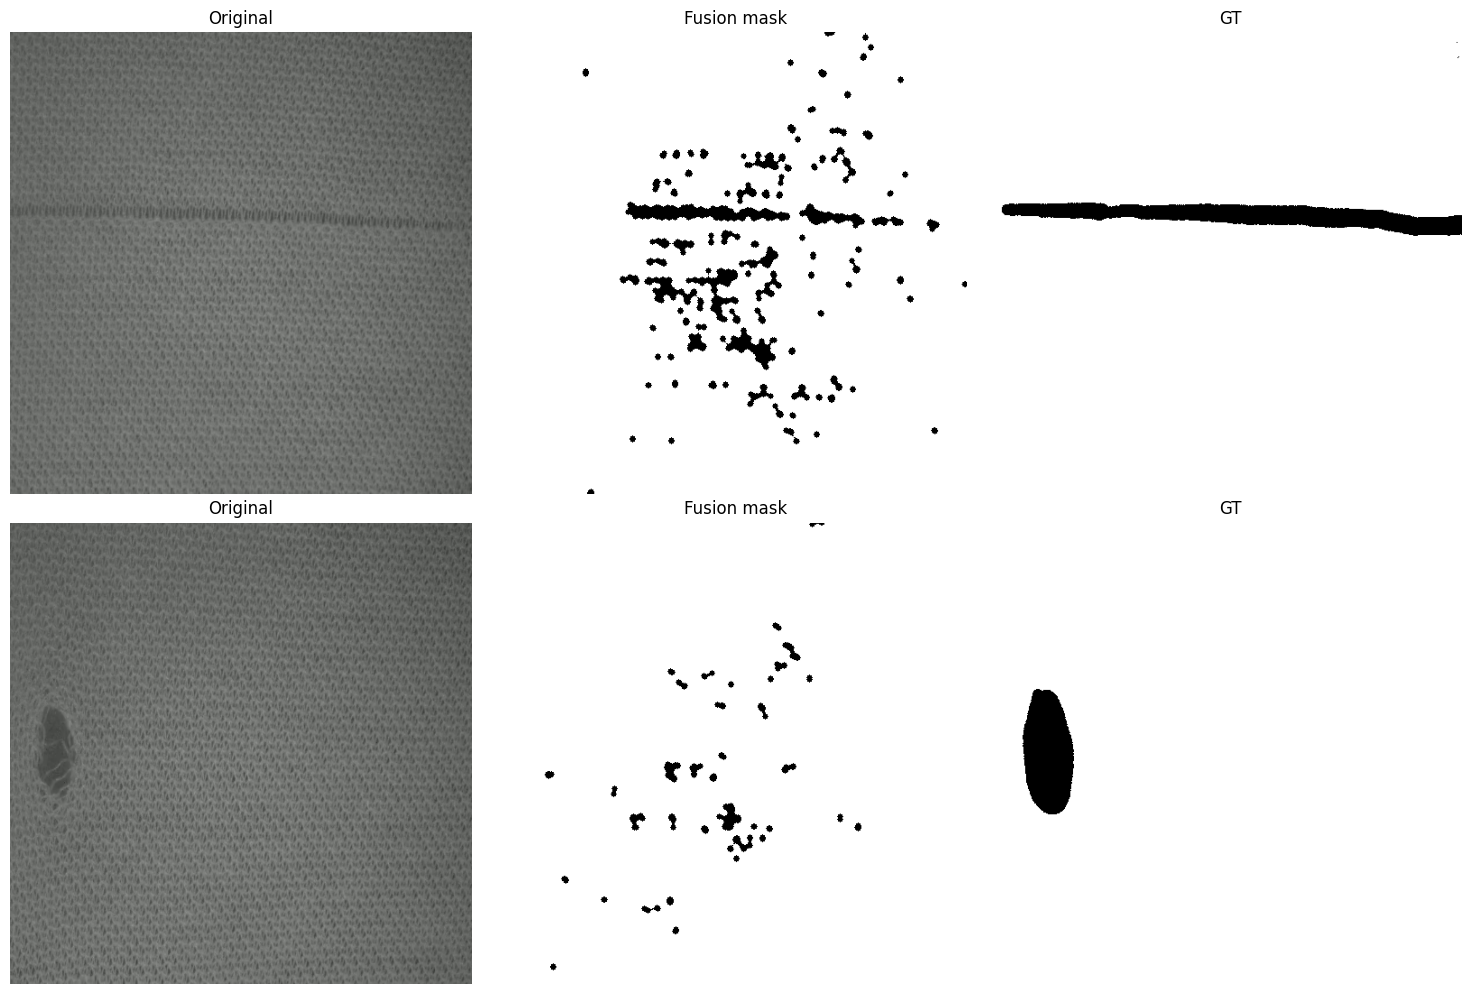

In [23]:
# Scikit-image fusion detector: Black-hat + LBP + Local Entropy
# Saves pixel masks to ./results_skimage and plots Original | Prediction | GT
import os
import sys
import subprocess
import cv2
import numpy as np
import matplotlib.pyplot as plt

out_dir = './results_skimage'
os.makedirs(out_dir, exist_ok=True)

def ensure_skimage():
    try:
        import skimage
        return True
    except Exception:
        print('Installing scikit-image...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-image'])
        try:
            import skimage
            return True
        except Exception as e:
            print('Failed to import scikit-image after install:', e)
            return False

if not ensure_skimage():
    print('scikit-image not available; skip this cell.')
else:
    from skimage.feature import local_binary_pattern
    from skimage.filters import threshold_otsu
    from skimage import img_as_ubyte
    from skimage.morphology import disk, remove_small_objects, opening, closing
    from skimage.filters import rank
    # fusion detector
    def detect_skimage_fusion(im, bh_kernel=31, lbp_P=8, lbp_R=1, entropy_disk=9, weights=(0.5,0.3,0.2), min_area=50):
        # im: RGB or gray (uint8)
        if im.ndim == 3:
            gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        else:
            gray = im.copy()
        # ensure uint8 for rank filters
        gray_uint8 = img_as_ubyte((gray.astype(np.float32) - gray.min()) / (np.ptp(gray) + 1e-9))
        # black-hat (detect dark defects)
        k = max(3, int(bh_kernel) | 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
        bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        bh_norm = (bh.astype(np.float32) - bh.min()) / (np.ptp(bh) + 1e-9)
        # LBP and entropy on LBP to capture texture changes
        lbp = local_binary_pattern(gray, P=lbp_P, R=lbp_R, method='uniform')
        lbp_u = img_as_ubyte((lbp - lbp.min()) / (np.ptp(lbp) + 1e-9))
        try:
            entropy_lbp = rank.entropy(lbp_u, disk(entropy_disk))
        except Exception:
            # fallback to local variance if entropy missing
            entropy_lbp = rank.mean(lbp_u, disk(entropy_disk))
        entropy_lbp_norm = (entropy_lbp.astype(np.float32) - entropy_lbp.min()) / (np.ptp(entropy_lbp) + 1e-9)
        # local entropy on gray
        try:
            entropy_gray = rank.entropy(gray_uint8, disk(entropy_disk))
        except Exception:
            entropy_gray = rank.mean(gray_uint8, disk(entropy_disk))
        entropy_gray_norm = (entropy_gray.astype(np.float32) - entropy_gray.min()) / (np.ptp(entropy_gray) + 1e-9)
        # fused score
        w_bh, w_e, w_l = weights
        fused = w_bh * bh_norm + w_e * entropy_gray_norm + w_l * entropy_lbp_norm
        fused_u8 = img_as_ubyte((fused - fused.min()) / (np.ptp(fused) + 1e-9))
        # threshold
        try:
            thr = threshold_otsu(fused_u8)
        except Exception:
            thr = np.percentile(fused_u8, 95)
        bw = (fused_u8 >= thr)
        # clean
        bw = opening(bw, disk(3))
        bw = closing(bw, disk(3))
        bw = remove_small_objects(bw.astype(bool), min_size=min_area)
        # bw True => anomaly (defect). Convert to required mask: defect=0, non-defect=255
        mask = np.ones_like(gray, dtype=np.uint8) * 255
        mask[np.where(bw)] = 0
        return mask, fused_u8

    # run fusion on images and save results
    try:
        img_paths, gt_paths = find_image_and_gt_pairs(img_folder)
    except Exception:
        raise RuntimeError('Run the earlier cells to set up image paths')

    for p in img_paths:
        orig = read_image(p)
        mask, fused = detect_skimage_fusion(orig, bh_kernel=31, lbp_P=8, lbp_R=1, entropy_disk=7, weights=(0.5,0.25,0.25), min_area=30)
        base = os.path.splitext(os.path.basename(p))[0]
        outp = os.path.join(out_dir, base + '_pred.png')
        cv2.imwrite(outp, mask)
        print('Saved scikit-image fusion mask to', outp)

    # plot results for inspection
    n = len(img_paths)
    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))
    if n == 1:
        axes = axes.reshape(1,3)
    for i, p in enumerate(img_paths):
        orig = read_image(p)
        base = os.path.splitext(os.path.basename(p))[0]
        predp = os.path.join(out_dir, base + '_pred.png')
        pred = cv2.imread(predp, cv2.IMREAD_UNCHANGED)
        if pred is None:
            pred = np.ones((orig.shape[0], orig.shape[1]), dtype=np.uint8)*255
        gt = None
        if i < len(gt_paths) and os.path.isfile(gt_paths[i]):
            gt_raw = cv2.imread(gt_paths[i], cv2.IMREAD_UNCHANGED)
            if gt_raw is not None:
                if gt_raw.ndim == 3:
                    ch = gt_raw.shape[2]
                    if ch >= 3:
                        gt = cv2.cvtColor(gt_raw, cv2.COLOR_BGR2GRAY)
                    elif ch == 1:
                        gt = gt_raw[:, :, 0]
                    else:
                        gt = gt_raw[:, :, 0]
                else:
                    gt = gt_raw
        if gt is None:
            gt = np.ones((orig.shape[0], orig.shape[1]), dtype=np.uint8)*255
        axes[i,0].imshow(orig); axes[i,0].axis('off'); axes[i,0].set_title('Original')
        axes[i,1].imshow(pred, cmap='gray', vmin=0, vmax=255); axes[i,1].axis('off'); axes[i,1].set_title('Fusion mask')
        axes[i,2].imshow(gt, cmap='gray', vmin=0, vmax=255); axes[i,2].axis('off'); axes[i,2].set_title('GT')
    plt.tight_layout(); plt.show()



0: 640x640 (no detections), 107.7ms
Speed: 4.7ms preprocess, 107.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 107.7ms
Speed: 4.7ms preprocess, 107.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Saved hybrid mask to ./results_hybrid\image1_pred.png
Image: image1.png -- Acc=0.9345 Prec=0.2801 Rec=0.5096 F1=0.3615

Saved hybrid mask to ./results_hybrid\image1_pred.png
Image: image1.png -- Acc=0.9345 Prec=0.2801 Rec=0.5096 F1=0.3615

0: 640x640 1 person, 115.4ms
Speed: 12.7ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 1 person, 115.4ms
Speed: 12.7ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Saved hybrid mask to ./results_hybrid\image2_pred.png
Image: image2.png -- Acc=0.9823 Prec=1.0000 Rec=0.2437 F1=0.3919
Average F1: 0.3767
Saved hybrid mask to ./results_hybrid\image2_pred.png
Image: image2.png -- Acc=0.9823 Prec=1.0000

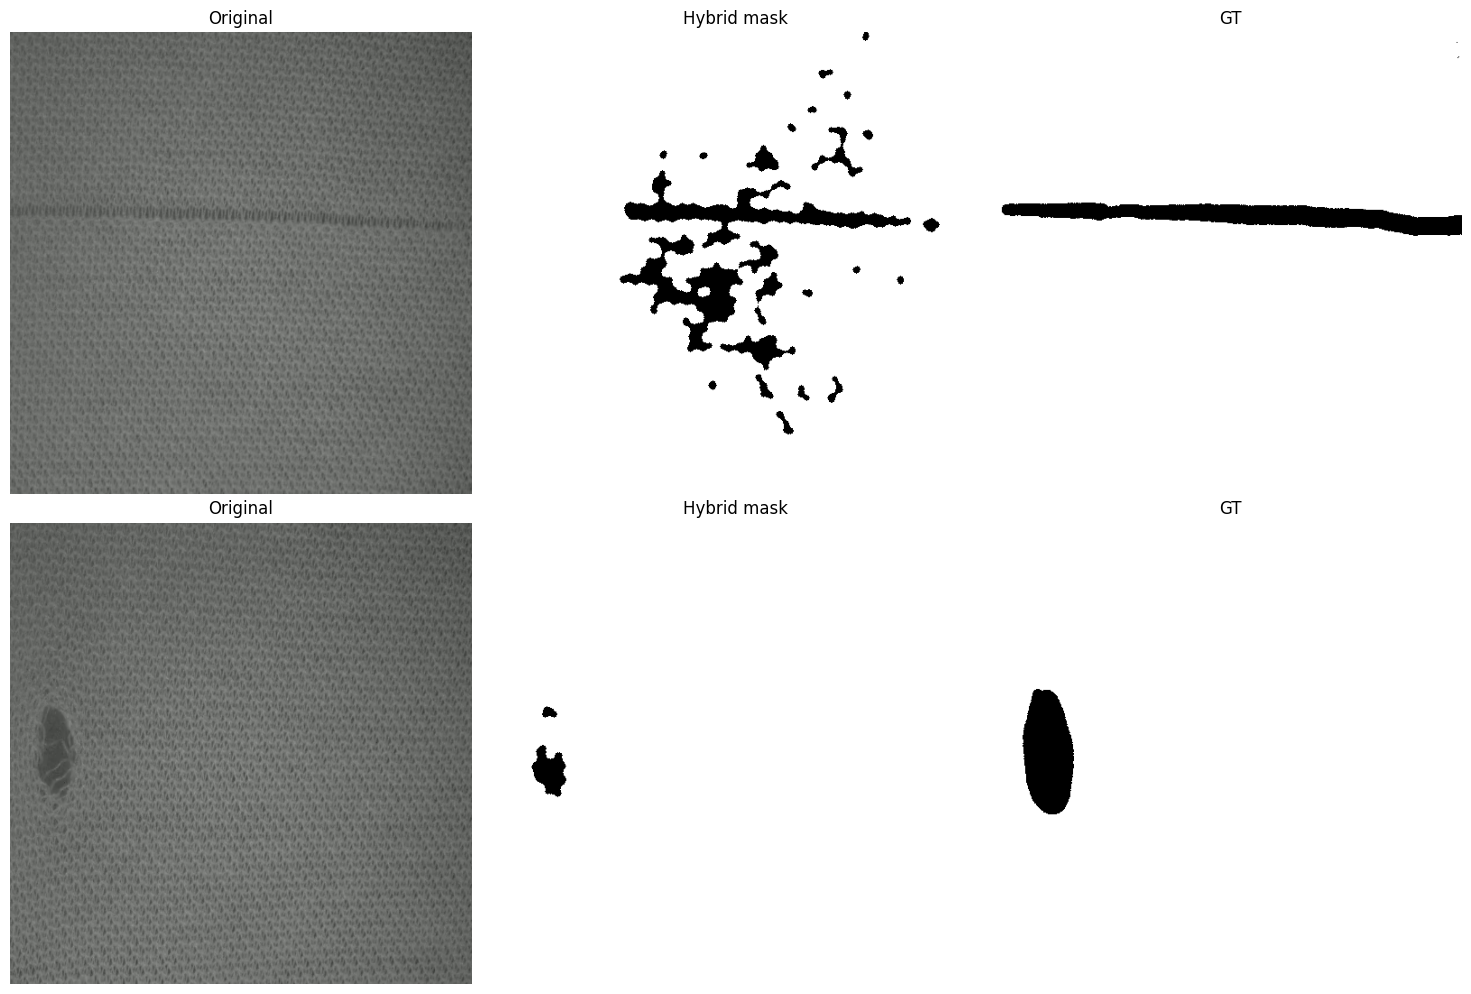

In [24]:
# Hybrid method: YOLO localization + scikit-image fusion for pixel masks
# Saves masks to ./results_hybrid and computes Accuracy/Precision/Recall/F1
import os
import sys
import subprocess
import cv2
import numpy as np
import matplotlib.pyplot as plt

out_dir = './results_hybrid'
os.makedirs(out_dir, exist_ok=True)

# ensure packages
try:
    import skimage
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-image'])
    import skimage

try:
    import ultralytics
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ultralytics'])
    import ultralytics

from ultralytics import YOLO
from skimage.feature import local_binary_pattern
from skimage import img_as_ubyte
from skimage.morphology import disk, remove_small_objects, opening, closing
from skimage.filters import rank
from skimage.filters import threshold_otsu

# load small YOLO model (downloads weights if needed)
model = YOLO('yolov8n.pt')

# reuse fusion detector defined earlier if present, else define a local version
try:
    detect_skimage_fusion
except NameError:
    def detect_skimage_fusion(im, bh_kernel=31, lbp_P=8, lbp_R=1, entropy_disk=7, weights=(0.5,0.25,0.25), min_area=30):
        if im.ndim == 3:
            gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        else:
            gray = im.copy()
        gray_uint8 = img_as_ubyte((gray.astype(np.float32) - gray.min()) / (np.ptp(gray) + 1e-9))
        # black-hat
        k = max(3, int(bh_kernel) | 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
        bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        bh_norm = (bh.astype(np.float32) - bh.min()) / (np.ptp(bh) + 1e-9)
        lbp = local_binary_pattern(gray, P=lbp_P, R=lbp_R, method='uniform')
        lbp_u = img_as_ubyte((lbp - lbp.min()) / (np.ptp(lbp) + 1e-9))
        try:
            entropy_lbp = rank.entropy(lbp_u, disk(entropy_disk))
        except Exception:
            entropy_lbp = rank.mean(lbp_u, disk(entropy_disk))
        entropy_lbp_norm = (entropy_lbp.astype(np.float32) - entropy_lbp.min()) / (np.ptp(entropy_lbp) + 1e-9)
        try:
            entropy_gray = rank.entropy(gray_uint8, disk(entropy_disk))
        except Exception:
            entropy_gray = rank.mean(gray_uint8, disk(entropy_disk))
        entropy_gray_norm = (entropy_gray.astype(np.float32) - entropy_gray.min()) / (np.ptp(entropy_gray) + 1e-9)
        w_bh, w_e, w_l = weights
        fused = w_bh * bh_norm + w_e * entropy_gray_norm + w_l * entropy_lbp_norm
        fused_u8 = img_as_ubyte((fused - fused.min()) / (np.ptp(fused) + 1e-9))
        try:
            thr = threshold_otsu(fused_u8)
        except Exception:
            thr = np.percentile(fused_u8, 95)
        bw = (fused_u8 >= thr)
        bw = opening(bw, disk(3))
        bw = closing(bw, disk(3))
        bw = remove_small_objects(bw.astype(bool), min_size=min_area)
        mask = np.ones_like(gray, dtype=np.uint8) * 255
        mask[np.where(bw)] = 0
        return mask, fused_u8

# helper metrics
from typing import Tuple

def compute_metrics(pred_mask: np.ndarray, gt_mask: np.ndarray) -> Tuple[int,int,int,int,float,float,float,float]:
    # pred_mask, gt_mask: uint8 255=non-defect, 0=defect
    pred_bin = (pred_mask == 0).astype(np.uint8)
    gt_bin = (gt_mask == 0).astype(np.uint8)
    tp = int(np.logical_and(pred_bin==1, gt_bin==1).sum())
    tn = int(np.logical_and(pred_bin==0, gt_bin==0).sum())
    fp = int(np.logical_and(pred_bin==1, gt_bin==0).sum())
    fn = int(np.logical_and(pred_bin==0, gt_bin==1).sum())
    total = tp+tn+fp+fn
    accuracy = (tp+tn)/total if total>0 else 0.0
    precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall)>0 else 0.0
    return tp,tn,fp,fn,accuracy,precision,recall,f1

# run hybrid pipeline
try:
    img_paths, gt_paths = find_image_and_gt_pairs(img_folder)
except Exception:
    raise RuntimeError('Run earlier cells to set up image paths')

metrics = []
for i, p in enumerate(img_paths):
    orig = read_image(p)  # RGB
    h,w = orig.shape[:2]
    full_mask = np.ones((h,w), dtype=np.uint8) * 255

    # YOLO detection
    rgb = orig.copy()
    results = model(rgb, imgsz=640, conf=0.25)
    res0 = results[0]
    boxes = []
    try:
        for box in res0.boxes.xyxy.cpu().numpy():
            boxes.append(box)
    except Exception:
        if hasattr(res0, 'boxes') and len(res0.boxes) > 0:
            for b in res0.boxes:
                xy = b.xyxy.tolist()[0]
                boxes.append(xy)

    if len(boxes) == 0:
        # fallback to fusion on entire image
        mask, fused = detect_skimage_fusion(orig)
        full_mask = mask
    else:
        # for each box, crop, run fusion, paste
        for b in boxes:
            x1, y1, x2, y2 = map(int, b[:4])
            # add small padding
            pad_x = int(0.05 * (x2-x1))
            pad_y = int(0.05 * (y2-y1))
            xa = max(0, x1-pad_x)
            xb = min(w, x2+pad_x)
            ya = max(0, y1-pad_y)
            yb = min(h, y2+pad_y)
            crop = orig[ya:yb, xa:xb]
            if crop.size == 0:
                continue
            mask_crop, fused_crop = detect_skimage_fusion(crop)
            # optional refinement: remove tiny objects inside crop
            mask_crop_bin = (mask_crop==0)
            mask_crop_bin = remove_small_objects(mask_crop_bin, min_size=20)
            mask_crop_ref = np.ones_like(mask_crop, dtype=np.uint8)*255
            mask_crop_ref[mask_crop_bin] = 0
            full_mask[ya:yb, xa:xb] = np.minimum(full_mask[ya:yb, xa:xb], mask_crop_ref)

    # global cleanup
    # fill small holes (closing) and remove small islands
    full_mask_bool = (full_mask==0)
    full_mask_bool = opening(full_mask_bool, disk(3))
    full_mask_bool = closing(full_mask_bool, disk(5))
    full_mask_bool = remove_small_objects(full_mask_bool, min_size=30)
    final_mask = np.ones_like(full_mask, dtype=np.uint8)*255
    final_mask[full_mask_bool] = 0

    outp = os.path.join(out_dir, os.path.splitext(os.path.basename(p))[0] + '_pred.png')
    cv2.imwrite(outp, final_mask)
    print('Saved hybrid mask to', outp)

    # load gt safely
    gt = None
    if i < len(gt_paths) and os.path.isfile(gt_paths[i]):
        gt_raw = cv2.imread(gt_paths[i], cv2.IMREAD_UNCHANGED)
        if gt_raw is not None:
            if gt_raw.ndim == 3:
                ch = gt_raw.shape[2]
                if ch >= 3:
                    gt = cv2.cvtColor(gt_raw, cv2.COLOR_BGR2GRAY)
                else:
                    gt = gt_raw[:, :, 0]
            else:
                gt = gt_raw
    if gt is None:
        gt = np.ones((h,w), dtype=np.uint8)*255

    tp,tn,fp,fn,acc,prec,rec,f1 = compute_metrics(final_mask, gt)
    metrics.append((os.path.basename(p), acc, prec, rec, f1))
    print(f'Image: {os.path.basename(p)} -- Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}')

# summary
if metrics:
    avg_f1 = np.mean([m[4] for m in metrics])
    print(f'Average F1: {avg_f1:.4f}')

# quick plot for visual check
n = len(img_paths)
fig, axs = plt.subplots(n, 3, figsize=(15, 5*n))
if n == 1:
    axs = axs.reshape(1,3)
for i, p in enumerate(img_paths):
    orig = read_image(p)
    pred = cv2.imread(os.path.join(out_dir, os.path.splitext(os.path.basename(p))[0] + '_pred.png'), cv2.IMREAD_UNCHANGED)
    if pred is None:
        pred = np.ones((orig.shape[0], orig.shape[1]), dtype=np.uint8)*255
    gt = None
    if i < len(gt_paths) and os.path.isfile(gt_paths[i]):
        gt_raw = cv2.imread(gt_paths[i], cv2.IMREAD_UNCHANGED)
        if gt_raw is not None:
            if gt_raw.ndim == 3:
                ch = gt_raw.shape[2]
                if ch >= 3:
                    gt = cv2.cvtColor(gt_raw, cv2.COLOR_BGR2GRAY)
                else:
                    gt = gt_raw[:, :, 0]
            else:
                gt = gt_raw
    if gt is None:
        gt = np.ones((orig.shape[0], orig.shape[1]), dtype=np.uint8)*255
    axs[i,0].imshow(orig); axs[i,0].axis('off'); axs[i,0].set_title('Original')
    axs[i,1].imshow(pred, cmap='gray', vmin=0, vmax=255); axs[i,1].axis('off'); axs[i,1].set_title('Hybrid mask')
    axs[i,2].imshow(gt, cmap='gray', vmin=0, vmax=255); axs[i,2].axis('off'); axs[i,2].set_title('GT')
plt.tight_layout(); plt.show()


In [25]:
# Cross-image stitching + synthetic augmentation
# - Stitch adjacent images, run combined detectors on the stitched image to catch defects that span images.
# - Optionally synthesize long defects across pairs for augmentation.
import os
import cv2
import numpy as np
out_cross = './results_crossimage'
os.makedirs(out_cross, exist_ok=True)

def stitch_pair(img1, img2, direction='horizontal', overlap=50):
    # img1, img2: RGB arrays
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if direction == 'horizontal':
        # ensure same height by padding/trimming
        H = max(h1, h2)
        A = np.ones((H, w1, 3), dtype=img1.dtype)*255
        B = np.ones((H, w2, 3), dtype=img2.dtype)*255
        A[:h1,:w1] = img1
        B[:h2,:w2] = img2
        # simple stitch with overlap: take left image then right image shifted by (w1-overlap)
        stitched = np.ones((H, w1 + w2 - overlap, 3), dtype=img1.dtype)*255
        stitched[:, :w1] = A[:, :w1]
        stitched[:, w1-overlap:] = B[:, :w2]  # B will overwrite overlap region
        return stitched, ('h', w1, w2, overlap)
    else:
        # vertical stitching (not used often here)
        W = max(w1, w2)
        A = np.ones((h1, W, 3), dtype=img1.dtype)*255
        B = np.ones((h2, W, 3), dtype=img2.dtype)*255
        A[:h1,:w1] = img1
        B[:h2,:w2] = img2
        stitched = np.ones((h1 + h2 - overlap, W, 3), dtype=img1.dtype)*255
        stitched[:h1, :] = A
        stitched[h1-overlap:, :] = B
        return stitched, ('v', h1, h2, overlap)

def split_stitched_mask(mask_stitched, meta):
    # mask_stitched: single-channel 0/255, meta returned by stitch_pair
    typ = meta[0]
    if typ == 'h':
        _, w1, w2, overlap = meta
        # left mask: [:, :w1] ; right mask: [:, w1-overlap: w1-overlap + w2]
        left = mask_stitched[:, :w1].copy()
        right = mask_stitched[:, w1-overlap: w1-overlap + w2].copy()
        return left, right
    else:
        _, h1, h2, overlap = meta
        top = mask_stitched[:h1, :].copy()
        bottom = mask_stitched[h1-overlap: h1-overlap + h2, :].copy()
        return top, bottom

def synthesize_cross_defect(img1, img2, thickness=12, color=0, direction='horizontal', position_ratio=0.5):
    # draw a dark line crossing from img1 to img2 across the seam to simulate a long defect
    stitched, meta = stitch_pair(img1, img2, direction=direction, overlap=50)
    h,w = stitched.shape[:2]
    # choose center at position_ratio along height
    cy = int(h * position_ratio)
    # draw a long line across full stitched width
    cv2.line(stitched, (0,cy), (w-1,cy), color=int(color), thickness=thickness)
    # split back
    return stitched, meta

# Run cross-image detection on adjacent pairs and save per-image masks
try:
    img_list  # reuse existing variable if present
except NameError:
    img_list, gt_list = find_image_and_gt_pairs(img_folder)

for i in range(len(img_list)-1):
    p1 = img_list[i]
    p2 = img_list[i+1]
    im1 = read_image(p1)
    im2 = read_image(p2)
    stitched, meta = stitch_pair(im1, im2, direction='horizontal', overlap=80)
    # run combined detectors on stitched image (reuse functions defined earlier):
    try:
        # prefer edge+aug combined pipeline if available
        _, fused_u8 = detect_skimage_fusion(stitched)
    except Exception:
        # fallback: compute simple grayscale fused approximation
        fused_u8 = cv2.cvtColor(stitched, cv2.COLOR_RGB2GRAY) if stitched.ndim==3 else stitched
    # get edge-based mask on stitched
    mask_edge = edge_proposal(stitched, fused_u8=fused_u8)
    # get multi-scale blackhat on stitched grayscale
    gray_st = cv2.cvtColor(stitched, cv2.COLOR_RGB2GRAY) if stitched.ndim==3 else stitched
    bhm = multi_scale_blackhat(gray_st)
    mask_bh = np.ones_like(gray_st, dtype=np.uint8)*255
    mask_bh[bhm>0] = 0
    # combine masks (OR):
    combined = np.logical_or(mask_edge==0, mask_bh==0)
    final_stitched = np.ones_like(gray_st, dtype=np.uint8)*255
    final_stitched[combined] = 0
    # split stitched mask back into per-image masks
    left_mask, right_mask = split_stitched_mask(final_stitched, meta)
    base1 = os.path.splitext(os.path.basename(p1))[0]
    base2 = os.path.splitext(os.path.basename(p2))[0]
    out1 = os.path.join(out_cross, base1 + '_crosspred.png')
    out2 = os.path.join(out_cross, base2 + '_crosspred.png')
    cv2.imwrite(out1, left_mask)
    cv2.imwrite(out2, right_mask)
    print('Saved cross-image masks for', base1, 'and', base2)

# Example: synthesize augmented pairs (optional) and save stitched images for inspection
if False:
    # set to True to generate synthetic augmentations for first few pairs
    for i in range(min(4, len(img_list)-1)):
        im1 = read_image(img_list[i])
        im2 = read_image(img_list[i+1])
        synth, meta = synthesize_cross_defect(im1, im2, thickness=16, color=0, direction='horizontal')
        base = os.path.splitext(os.path.basename(img_list[i]))[0] + '__' + os.path.splitext(os.path.basename(img_list[i+1]))[0]
        cv2.imwrite(os.path.join(out_cross, base + '_stitched_synth.png'), cv2.cvtColor(synth, cv2.COLOR_RGB2BGR) if synth.ndim==3 else synth)
        print('Saved synthesized stitched example', base + '_stitched_synth.png')

print('Cross-image detection completed. Results in', out_cross)


Saved cross-image masks for image1 and image2
Cross-image detection completed. Results in ./results_crossimage
